$$\huge{\textbf{Finansal Sentiment Analizi}}$$

# Sorun Bildirimi

The main task is to detect the tone of the financial text i.e, positive,negative or neutral using Deep Learning approaches.

# Veri seti açıklaması

Aşağıdaki veriler finansal duygu analizi araştırmalarını ilerletmek için tasarlanmıştır. İki veri kümesi (FiQA, Financial PhraseBank) tek bir kullanımı kolay CSV dosyasında birleştirilmiştir. Duygu etiketleriyle finansal cümleler sağlar.

Veri setini indirmek için bağlantı (kaynak): https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis

# Methodoloji

Görevin metodolojisi aşağıdakileri içerecektir:

1. Veri Ön İşleme:

Veri ön işleme, model eğitimi için verilerin belirteçleştirilmesini, vektörleştirilmesini ve eğitim testi bölünmesini içerir.

2. Modeller:

Verileri eğitmek için kullanılacak modeller şunlardır:
 - Basic LSTM
 - Glove + LSTM
 - Glove + GRU
 - FastText + LSTM

## Veri ön işleme

### Text_Hammer yüklenmesi:
!pip install text_hammer

In [11]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import text_hammer as th
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm

In [12]:
df = pd.read_csv('../input/financial-sentiment-analysis/data.csv')

In [13]:
df.head(14)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


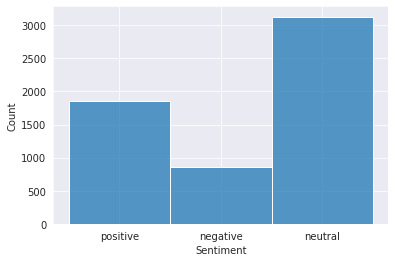

In [14]:
import seaborn as sns
sns.set_style('darkgrid')
sns.histplot(x='Sentiment',data=df)
plt.show()

In [15]:
df['len'] = list(map(lambda x: len(str(x).split(' ')),df['Sentence']))
df.head()

,Sentence,Sentiment,len
0,The GeoSolutions technology will leverage Bene...,positive,32
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,11
2,"For the last quarter of 2010 , Componenta 's n...",positive,39
3,According to the Finnish-Russian Chamber of Co...,neutral,20
4,The Swedish buyout firm has sold its remaining...,neutral,23


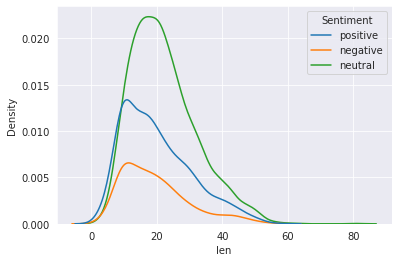

In [16]:
sns.kdeplot(x='len',hue='Sentiment',data=df)
plt.show()

In [17]:
mapdf = {'positive':0,'negative':1,'neutral':2}
df['Sentiment'] = list(map(lambda x:mapdf[x],df['Sentiment']))
df.head()

,Sentence,Sentiment,len
0,The GeoSolutions technology will leverage Bene...,0,32
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1,11
2,"For the last quarter of 2010 , Componenta 's n...",0,39
3,According to the Finnish-Russian Chamber of Co...,2,20
4,The Swedish buyout firm has sold its remaining...,2,23


In [18]:
print(df['Sentiment'].corr(df['len']))

0.10137114484667775


In [19]:
sentences = df['Sentence'].copy()[:]
sentences = sentences.to_list()
sentences = list(map(lambda x: x.lower(),sentences))
sentences = list(map(lambda x: th.cont_exp(x),sentences))
sentences = list(map(lambda x: th.remove_emails(x),sentences))
sentences = list(map(lambda x: th.remove_emails(x),sentences))
sentences = list(map(lambda x: th.remove_html_tags(x),sentences))
sentences = list(map(lambda x: th.remove_stopwords(x),sentences))
sentences = list(map(lambda x: th.remove_special_chars(x),sentences))
sentences = list(map(lambda x: th.remove_accented_chars(x),sentences))
sentences = list(map(lambda x: th.make_base(x),sentences))

In [20]:
sentences[:5]

['geosolution technology leverage benefon global positioning system solution provide location base search technology community platform location relevant multimedia content new powerful commercial model',
 'esi lows 150 250 bk real possibility',
 'quarter 2010 componenta net sale double eur131 m eur76 m period year early move zero pretax profit pretax loss eur7 m',
 'accord finnishrussian chamber commerce major construction company finland operate russia',
 'swedish buyout firm sell remain 224 percent stake eighteen month take company public finland']

In [21]:
import nltk
pairs = []
for sent in tqdm(sentences):
    pairs.extend(nltk.word_tokenize(sent))
freq = nltk.FreqDist(pairs)
freq.most_common(14)

  0%|          | 0/5842 [00:00<?, ?it/s]

[('eur', 1284),
 ('company', 915),
 ('mn', 729),
 ('sale', 595),
 ('profit', 584),
 ('say', 574),
 ('finnish', 527),
 ('share', 512),
 ('net', 499),
 ('million', 493),
 ('m', 453),
 ('year', 377),
 ('2009', 352),
 ('mln', 348)]

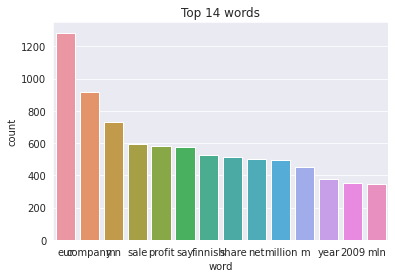

In [22]:
tempdf = pd.DataFrame(freq.most_common(14),  columns=['word', 'count'])
sns.barplot(x='word',y='count',data=tempdf)
plt.title("Top 14 words")
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
from keras.utils.all_utils import to_categorical
y = to_categorical(df['Sentiment'])
x = sentences.copy()
X_train,X_test, y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=72)

## Vektörizasyon

In [24]:
from keras.preprocessing.text import Tokenizer
num_words = 12000 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([pd.Series(X_train), pd.Series(X_test)], axis = 0)
tokenizer.fit_on_texts(df_total)

In [25]:
from keras.preprocessing.sequence import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=81,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 81, padding = 'post')

In [26]:
print(X_train_pad.shape,X_test_pad.shape)

(4089, 81) (1753, 81)


## LSTM

In [27]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Bidirectional,Embedding,Dropout

In [28]:
lstm = Sequential()
lstm.add(Embedding(input_dim = num_words,
                          output_dim = 100,
                          input_length= X_train_pad.shape[1]))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(128,return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(256,return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(128,return_sequences=False)))
lstm.add(Dense(64,activation='tanh'))
lstm.add(Dense(32,activation='tanh'))
lstm.add(Dense(10,activation='tanh'))
lstm.add(Dense(3,activation='softmax'))

In [29]:
lstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [30]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 81, 100)           1200000   
_________________________________________________________________
dropout (Dropout)            (None, 81, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 81, 256)           234496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 81, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 81, 512)           1050624   
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 512)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)              

In [31]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [32]:
lstm_history = lstm.fit(X_train_pad,y_train, epochs = 10, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/10
64/64 [==============================] - 14s 79ms/step - loss: 0.9424 - accuracy: 0.5688 - val_loss: 0.8493 - val_accuracy: 0.6537

Epoch 00001: val_accuracy improved from -inf to 0.65374, saving model to ./model.h5
Epoch 2/10
64/64 [==============================] - 3s 53ms/step - loss: 0.6043 - accuracy: 0.7586 - val_loss: 0.7724 - val_accuracy: 0.6646

Epoch 00002: val_accuracy improved from 0.65374 to 0.66458, saving model to ./model.h5
Epoch 3/10
64/64 [==============================] - 3s 53ms/step - loss: 0.3980 - accuracy: 0.8423 - val_loss: 0.8547 - val_accuracy: 0.6440

Epoch 00003: val_accuracy did not improve from 0.66458
Epoch 4/10
64/64 [==============================] - 3s 53ms/step - loss: 0.2713 - accuracy: 0.8860 - val_loss: 1.0110 - val_accuracy: 0.6400

Epoch 00004: val_accuracy did not improve from 0.66458
Epoch 5/10
64/64 [==============================] - 3s 53ms/step - loss: 0.2193 - accuracy: 0.9019 - val_loss: 1.1999 - val_accuracy: 0.6292

Epoch 00

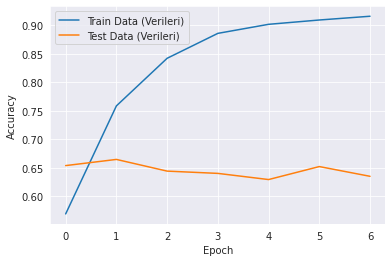

In [33]:
plt.plot(lstm_history.history['accuracy'], label='Train Data (Verileri)')
plt.plot(lstm_history.history['val_accuracy'], label='Test Data (Verileri)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

#plt.ylim([0.8, 1])
plt.legend(loc='best')
plt.show()

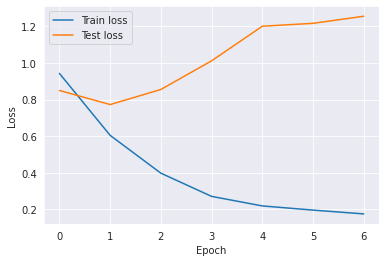

In [34]:
plt.plot(lstm_history.history['loss'], label='Train loss')
plt.plot(lstm_history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [35]:
from sklearn.metrics import classification_report
predictions = lstm.predict(X_test_pad)
target_names=['positive','negative','neutral']
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1),target_names=target_names))

              precision    recall  f1-score   support

    positive       0.68      0.65      0.66       556
    negative       0.32      0.37      0.34       258
     neutral       0.71      0.70      0.70       939

    accuracy                           0.63      1753
   macro avg       0.57      0.57      0.57      1753
weighted avg       0.64      0.63      0.64      1753



## Glove+LSTM

In [36]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-300')

In [37]:
glove_gensim.most_similar(positive=['king','woman'],negative=['man'],topn=1)

[('queen', 0.6713277101516724)]

In [38]:
vector_size = 300
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tqdm(tokenizer.word_index.items()):
    if index < num_words: # since index starts with zero 
        try:
            gensim_weight_matrix[index] = glove_gensim[word]
        except:
            gensim_weight_matrix[index] = np.zeros(300)

  0%|          | 0/10891 [00:00<?, ?it/s]

In [39]:
gensim_weight_matrix.shape

(12000, 300)

In [40]:
glove = Sequential()
glove.add(Embedding(input_dim = num_words,
                          output_dim = 300,
                          input_length= X_train_pad.shape[1],
                          weights = [gensim_weight_matrix],
                          trainable = False))
glove.add(Dropout(0.2))
glove.add(Bidirectional(LSTM(128,return_sequences=True)))
glove.add(Dropout(0.2))
glove.add(Bidirectional(LSTM(256,return_sequences=True)))
glove.add(Dropout(0.2))
glove.add(Bidirectional(LSTM(128,return_sequences=False)))
glove.add(Dense(64,activation='tanh'))
glove.add(Dense(32,activation='tanh'))
glove.add(Dense(10,activation='tanh'))
glove.add(Dense(3,activation='softmax'))

In [41]:
glove.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 300)           3600000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 81, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 81, 256)           439296    
_________________________________________________________________
dropout_4 (Dropout)          (None, 81, 256)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 81, 512)           1050624   
_________________________________________________________________
dropout_5 (Dropout)          (None, 81, 512)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)              

In [42]:
glove.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
glove_history = glove.fit(X_train_pad,y_train, epochs = 10, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/10
64/64 [==============================] - 12s 78ms/step - loss: 0.8509 - accuracy: 0.6070 - val_loss: 0.7724 - val_accuracy: 0.6418

Epoch 00001: val_accuracy did not improve from 0.66458
Epoch 2/10
64/64 [==============================] - 3s 54ms/step - loss: 0.7152 - accuracy: 0.6838 - val_loss: 0.7297 - val_accuracy: 0.6703

Epoch 00002: val_accuracy improved from 0.66458 to 0.67028, saving model to ./model.h5
Epoch 3/10
64/64 [==============================] - 3s 54ms/step - loss: 0.6515 - accuracy: 0.7234 - val_loss: 0.7081 - val_accuracy: 0.6880

Epoch 00003: val_accuracy improved from 0.67028 to 0.68796, saving model to ./model.h5
Epoch 4/10
64/64 [==============================] - 3s 54ms/step - loss: 0.5956 - accuracy: 0.7457 - val_loss: 0.7016 - val_accuracy: 0.6874

Epoch 00004: val_accuracy did not improve from 0.68796
Epoch 5/10
64/64 [==============================] - 3s 54ms/step - loss: 0.5599 - accuracy: 0.7640 - val_loss: 0.7574 - val_accuracy: 0.6885

Epoch

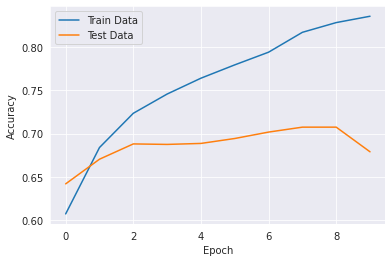

In [44]:
plt.plot(glove_history.history['accuracy'], label='Train Data')
plt.plot(glove_history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.98, 1])
plt.legend(loc='best')
plt.show()

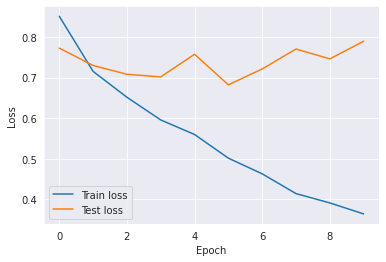

In [45]:
plt.plot(glove_history.history['loss'], label='Train loss')
plt.plot(glove_history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [46]:
predictions = glove.predict(X_test_pad)
target_names=['positive','negative','neutral']
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1),target_names=target_names))

              precision    recall  f1-score   support

    positive       0.66      0.71      0.69       556
    negative       0.42      0.45      0.44       258
     neutral       0.77      0.72      0.74       939

    accuracy                           0.68      1753
   macro avg       0.62      0.63      0.62      1753
weighted avg       0.68      0.68      0.68      1753



## Glove+GRU

In [47]:
from keras.layers import GRU
gru = Sequential()
gru.add(Embedding(input_dim = num_words,
                          output_dim = 300,
                          input_length= X_train_pad.shape[1],
                          weights = [gensim_weight_matrix],
                          trainable = False))
gru.add(Dropout(0.2))
gru.add(Bidirectional(GRU(128,return_sequences=True)))
gru.add(Dropout(0.2))
gru.add(Bidirectional(GRU(256,return_sequences=True)))
gru.add(Dropout(0.2))
gru.add(Bidirectional(GRU(128,return_sequences=False)))
gru.add(Dense(64,activation='tanh'))
gru.add(Dense(32,activation='tanh'))
gru.add(Dense(10,activation='tanh'))
gru.add(Dense(3,activation='softmax'))

In [48]:
gru.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 300)           3600000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 81, 300)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 81, 256)           330240    
_________________________________________________________________
dropout_7 (Dropout)          (None, 81, 256)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 81, 512)           789504    
_________________________________________________________________
dropout_8 (Dropout)          (None, 81, 512)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)              

In [49]:
gru.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [50]:
gru_history = gru.fit(X_train_pad,y_train, epochs = 10, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/10
64/64 [==============================] - 11s 69ms/step - loss: 0.8936 - accuracy: 0.5957 - val_loss: 0.8042 - val_accuracy: 0.6549

Epoch 00001: val_accuracy did not improve from 0.70736
Epoch 2/10
64/64 [==============================] - 3s 47ms/step - loss: 0.7430 - accuracy: 0.6828 - val_loss: 0.7508 - val_accuracy: 0.6674

Epoch 00002: val_accuracy did not improve from 0.70736
Epoch 3/10
64/64 [==============================] - 3s 47ms/step - loss: 0.6847 - accuracy: 0.7166 - val_loss: 0.7183 - val_accuracy: 0.6834

Epoch 00003: val_accuracy did not improve from 0.70736
Epoch 4/10
64/64 [==============================] - 3s 47ms/step - loss: 0.6250 - accuracy: 0.7315 - val_loss: 0.7057 - val_accuracy: 0.6914

Epoch 00004: val_accuracy did not improve from 0.70736
Epoch 5/10
64/64 [==============================] - 3s 47ms/step - loss: 0.5721 - accuracy: 0.7547 - val_loss: 0.6825 - val_accuracy: 0.7114

Epoch 00005: val_accuracy improved from 0.70736 to 0.71135, saving mo

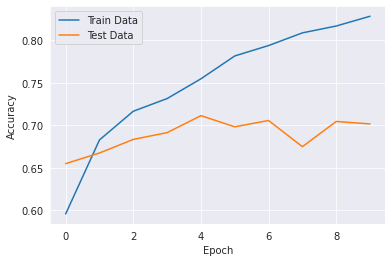

In [51]:
plt.plot(gru_history.history['accuracy'], label='Train Data')
plt.plot(gru_history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

#plt.ylim([0.7, 1])
plt.legend(loc='best')
plt.show()

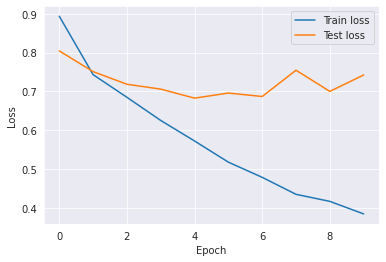

In [52]:
plt.plot(gru_history.history['loss'], label='Train loss')
plt.plot(gru_history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [53]:
predictions = gru.predict(X_test_pad)
target_names=['positive','negative','neutral']
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1),target_names=target_names))

              precision    recall  f1-score   support

    positive       0.71      0.75      0.73       556
    negative       0.43      0.50      0.46       258
     neutral       0.79      0.73      0.76       939

    accuracy                           0.70      1753
   macro avg       0.64      0.66      0.65      1753
weighted avg       0.71      0.70      0.71      1753



## Fasttext+LSTM

In [55]:
import gensim.downloader as api
glove_gensim  = api.load('fasttext-wiki-news-subwords-300')

In [56]:
vector_size = 300
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tqdm(tokenizer.word_index.items()):
    if index < num_words: # since index starts with zero 
        try:
            gensim_weight_matrix[index] = glove_gensim[word]
        except:
            gensim_weight_matrix[index] = np.zeros(300)

  0%|          | 0/10891 [00:00<?, ?it/s]

In [57]:
ftext = Sequential()
ftext.add(Embedding(input_dim = num_words,
                          output_dim = 300,
                          input_length= X_train_pad.shape[1],
                          weights = [gensim_weight_matrix],
                          trainable = False))
ftext.add(Dropout(0.2))
ftext.add(Bidirectional(LSTM(128,return_sequences=True)))
ftext.add(Dropout(0.2))
ftext.add(Bidirectional(LSTM(256,return_sequences=True)))
ftext.add(Dropout(0.2))
ftext.add(Bidirectional(LSTM(128,return_sequences=False)))
ftext.add(Dense(64,activation='tanh'))
ftext.add(Dense(32,activation='tanh'))
ftext.add(Dense(10,activation='tanh'))
ftext.add(Dense(3,activation='softmax'))

In [58]:
ftext.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 81, 300)           3600000   
_________________________________________________________________
dropout_9 (Dropout)          (None, 81, 300)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 81, 256)           439296    
_________________________________________________________________
dropout_10 (Dropout)         (None, 81, 256)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 81, 512)           1050624   
_________________________________________________________________
dropout_11 (Dropout)         (None, 81, 512)           0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)              

In [59]:
ftext.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [60]:
ftext_history = ftext.fit(X_train_pad,y_train, epochs = 10, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/10
64/64 [==============================] - 12s 77ms/step - loss: 0.9164 - accuracy: 0.5691 - val_loss: 0.8315 - val_accuracy: 0.6343

Epoch 00001: val_accuracy did not improve from 0.71135
Epoch 2/10
64/64 [==============================] - 3s 53ms/step - loss: 0.8182 - accuracy: 0.6349 - val_loss: 0.8226 - val_accuracy: 0.6338

Epoch 00002: val_accuracy did not improve from 0.71135
Epoch 3/10
64/64 [==============================] - 3s 54ms/step - loss: 0.7471 - accuracy: 0.6691 - val_loss: 0.8405 - val_accuracy: 0.6452

Epoch 00003: val_accuracy did not improve from 0.71135
Epoch 4/10
64/64 [==============================] - 3s 54ms/step - loss: 0.7280 - accuracy: 0.6831 - val_loss: 0.8024 - val_accuracy: 0.6326

Epoch 00004: val_accuracy did not improve from 0.71135
Epoch 5/10
64/64 [==============================] - 3s 53ms/step - loss: 0.7068 - accuracy: 0.6875 - val_loss: 0.7248 - val_accuracy: 0.6691

Epoch 00005: val_accuracy did not improve from 0.71135
Epoch 6/10
64/

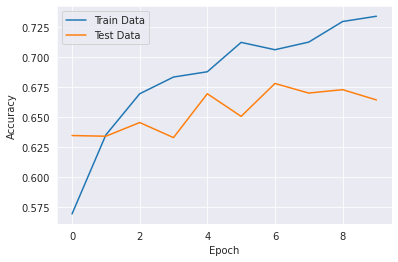

In [61]:
plt.plot(ftext_history.history['accuracy'], label='Train Data')
plt.plot(ftext_history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.8, 1])
plt.legend(loc='best')
plt.show()

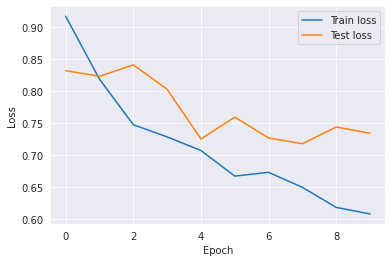

In [62]:
plt.plot(ftext_history.history['loss'], label='Train loss')
plt.plot(ftext_history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [63]:
predictions = ftext.predict(X_test_pad)
target_names=['positive','negative','neutral']
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1),target_names=target_names))

              precision    recall  f1-score   support

    positive       0.71      0.60      0.65       556
    negative       0.38      0.52      0.44       258
     neutral       0.75      0.74      0.74       939

    accuracy                           0.66      1753
   macro avg       0.61      0.62      0.61      1753
weighted avg       0.68      0.66      0.67      1753



## Sonuçlar

|S.No|Vector Embedding|Reccurent layer|Accuracy|
|--|--|--|--|
|1|None|LSTM|65%|
|2|Glove|LSTM|70%|
|3|Glove|GRU|72%|
|4|FastText|LSTM|68%|

# Çözüm

Çalışmanın temel amacı, finansal haberlerin tonunu belirleyebilen bir model üretmektir. Bu, çeşitli yerleştirmeler kullanan LSTM ve GRU gibi RNN modelleri kullanılarak gerçekleştirilir. Sınıflar dengesiz olduğundan ve en iyi doğruluğun %72 olan GLove+GRU modeli tarafından üretildiğinden, veri setinin tonu mükemmel bir şekilde belirleyebilecek kadar yetenekli olmadığı unutulmamalıdır.

Bu çalışmanın gerçek hayattaki uygulaması, finansal analizin otomasyonu, kar ve zararların kolayca çıkarılması ve daha birçokları gibi çeşitli yaklaşımlarda faydalı olabilir. Bu çalışma, daha karmaşık yaklaşımlar oluşturmada başlangıç ​​​​adımıdır.